In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LC_sweep = np.load('LC_sweep_data_20190921_201251.npz')
coarse, mid, fine, LC_code, counts_LC = LC_sweep['coarse'], LC_sweep['mid'], LC_sweep['fine'], LC_sweep['LC_code'], LC_sweep['counts_LC']

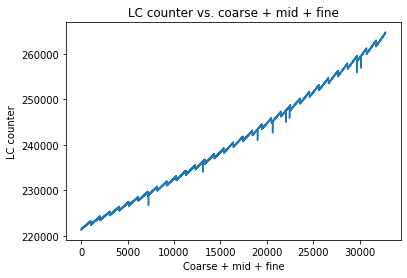

In [3]:
plt.plot(LC_code, counts_LC)
plt.title('LC counter vs. coarse + mid + fine')
plt.xlabel('Coarse + mid + fine')
plt.ylabel('LC counter')
plt.show()

In [4]:
def read_LC_counter(coarse, mid, fine):
    LC_code = (coarse << 10) | (mid << 5) | (fine)
    return counts_LC[LC_code]

def LC_monotonic(code, mid0, coarse0):
    code %= coarse0
    mid = code // mid0 + 1
    fine = code % mid0 + 1
    return mid, fine

In [5]:
LC_monotonic(117, 14, 118)

(9, 6)

In [6]:
# Find range of coarse to test (between 2.3GHz and 2.5GHz)
coarse_codes = []

for coarse in range(32):
    LC_count = read_LC_counter(coarse, 15, 0)
    LC_freq_1k = LC_count / 1000 * 960 * 10
        
    if LC_freq_1k > 2.35e6 and LC_freq_1k < 2.52e6:
        coarse_codes.append(coarse)
    
    if LC_freq_1k > 2.52e6:
        break

print('Coarse codes:', coarse_codes)

Coarse codes: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [7]:
min_diff = 8
max_diff = 20

In [8]:
# Tune mid0
mid0_codes = []
coarse0 = 2000 # Unused

for coarse in coarse_codes:
    mid0 = 15
    mon_build_min0_complete = False

    while not mon_build_min0_complete:
        mid, fine = LC_monotonic(5 * mid0, mid0, coarse0)
        current_LC_counter = read_LC_counter(coarse, mid, fine)
                
        mid, fine = LC_monotonic(5 * mid0 - 1, mid0, coarse0)
        previous_LC_counter = read_LC_counter(coarse, mid, fine)
        
        if current_LC_counter < previous_LC_counter + min_diff:
            mid0 -= 1
        elif current_LC_counter > previous_LC_counter + max_diff:
            mid0 += 1
        else:
            mid0_codes.append(mid0)
            mon_build_min0_complete = True

print('Mid0 codes:', mid0_codes)

Mid0 codes: [9, 8, 9, 9, 9, 9, 9, 10, 9, 10, 10]


In [9]:
# Tune coarse0
coarse0_codes = []

for i, coarse in enumerate(coarse_codes):
    coarse0 = 150
    mid0 = mid0_codes[i]
    mon_build_coarse0_complete = False
    
    while not mon_build_coarse0_complete:
        mid, fine = LC_monotonic(coarse0, mid0, coarse0)
        current_LC_counter = read_LC_counter(coarse + 1, mid, fine)
                                
        mid, fine = LC_monotonic(coarse0 - 1, mid0, coarse0)
        previous_LC_counter = read_LC_counter(coarse, mid, fine)
                                        
        if current_LC_counter < previous_LC_counter + min_diff:
            coarse0 -= 1
        elif current_LC_counter > previous_LC_counter + max_diff:
            coarse0 += 1
        else:
            coarse0_codes.append(coarse0)
            mon_build_coarse0_complete = True

print('Coarse0 codes:', coarse0_codes)

Coarse0 codes: [166, 148, 166, 166, 166, 166, 166, 185, 168, 185, 185]


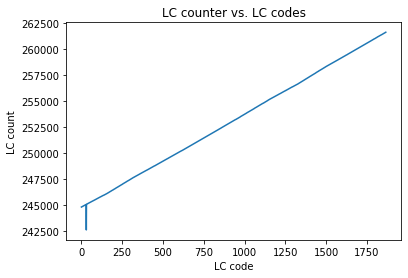

In [10]:
LC_counts = []

for i, coarse in enumerate(coarse_codes):    
    for code in range(coarse0_codes[i]):
            mid, fine = LC_monotonic(code, mid0_codes[i], coarse0_codes[i])
            LC_counts.append(read_LC_counter(coarse, mid, fine))

plt.plot(LC_counts)
plt.title('LC counter vs. LC codes')
plt.xlabel('LC code')
plt.ylabel('LC count')
plt.show()

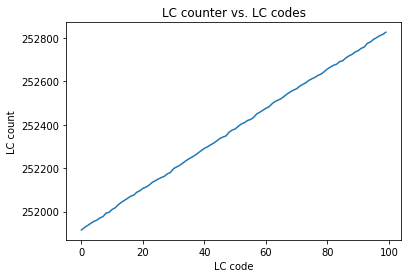

In [11]:
plt.plot(LC_counts[800:900])
plt.title('LC counter vs. LC codes')
plt.xlabel('LC code')
plt.ylabel('LC count')
plt.show()

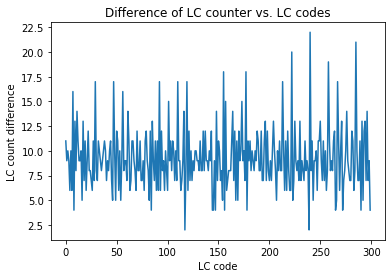

In [12]:
plt.plot(np.diff(LC_counts)[800:1100])
plt.title('Difference of LC counter vs. LC codes')
plt.xlabel('LC code')
plt.ylabel('LC count difference')
plt.show()

In [13]:
coarse_rollovers = []

def generate_coarse_rollovers(coarse0_codes):
    coarse_rollovers.append(coarse0_codes[0])
        
    for i in range(1, len(coarse0_codes)):
        coarse_rollovers.append(coarse0_codes[i] + coarse_rollovers[i - 1])

generate_coarse_rollovers(coarse0_codes)

In [14]:
def LC_monotonic_final(LC_code):    
    code_index = len(coarse_codes) - 1
    for i in range(len(coarse_rollovers)):
        if LC_code < coarse_rollovers[i]:
            code_index = i
            break
    
    coarse = coarse_codes[code_index]
    mid, fine = LC_monotonic(LC_code - coarse_rollovers[code_index], mid0_codes[code_index], coarse0_codes[code_index])
    return coarse, mid, fine

In [15]:
LC_codes = np.arange(coarse_rollovers[-1])
LC_counts_final = [read_LC_counter(*LC_monotonic_final(code)) for code in LC_codes]

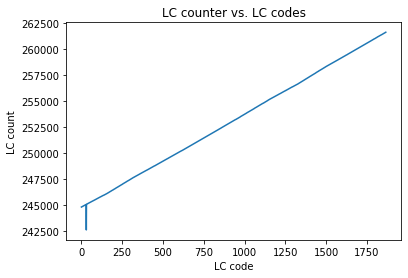

In [16]:
plt.plot(LC_codes, LC_counts_final)
plt.title('LC counter vs. LC codes')
plt.xlabel('LC code')
plt.ylabel('LC count')
plt.show()

In [17]:
LC_code_sweep = np.load('LC_code_sweep_data_20190930_183612.npz')
LC_code_codes, counts_LC_code = LC_code_sweep['LC_code'], LC_code_sweep['counts_LC']

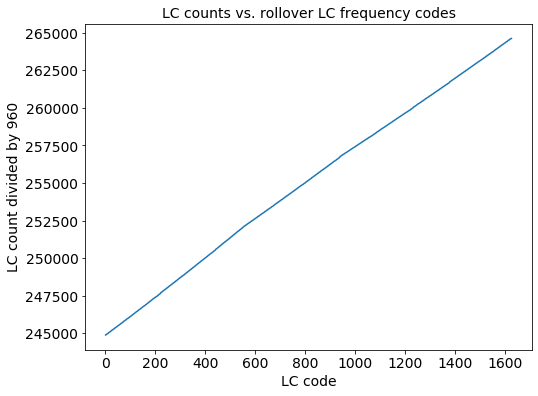

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(LC_code_codes[1:], counts_LC_code[1:])
plt.title('LC counts vs. rollover LC frequency codes', fontsize=14)
plt.xlabel('LC code', fontsize=14)
plt.ylabel('LC count divided by 960', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('lc_rollover.pdf', bbox_inches='tight')
plt.show()

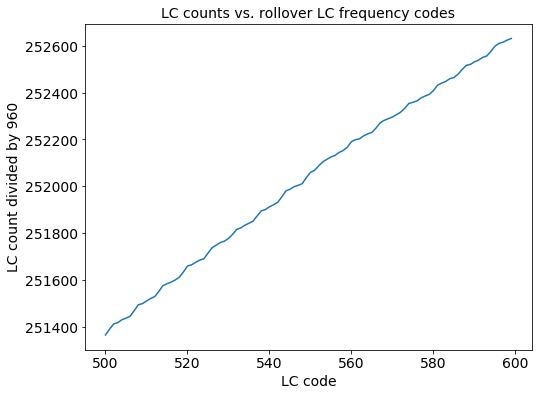

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(LC_code_codes[500:600], counts_LC_code[500:600])
plt.title('LC counts vs. rollover LC frequency codes', fontsize=14)
plt.xlabel('LC code', fontsize=14)
plt.ylabel('LC count divided by 960', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('lc_rollover_zoom.pdf', bbox_inches='tight')
plt.show()

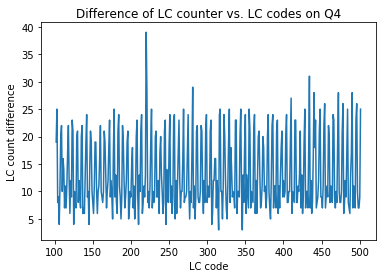

In [20]:
plt.plot(LC_code_codes[2:][100:500], np.diff(counts_LC_code)[1:][100:500])
plt.title('Difference of LC counter vs. LC codes on Q4')
plt.xlabel('LC code')
plt.ylabel('LC count difference')
plt.show()

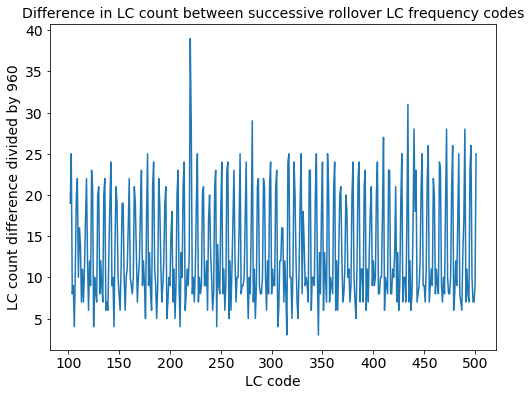

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(LC_code_codes[2:][100:500], np.diff(counts_LC_code)[1:][100:500])
plt.title('Difference in LC count between successive rollover LC frequency codes', fontsize=14)
plt.xlabel('LC code', fontsize=14)
plt.ylabel('LC count difference divided by 960', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('lc_rollover_diff_zoom.pdf', bbox_inches='tight')
plt.show()

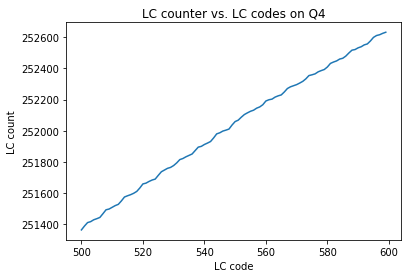

In [22]:
plt.plot(LC_code_codes[500:600], counts_LC_code[500:600])
plt.title('LC counter vs. LC codes on Q4')
plt.xlabel('LC code')
plt.ylabel('LC count')
plt.show()